In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ECHO
from ECHO.read_utils import read_ulog, read_tlog_txt
from glob import glob
import healpy as hp
import pandas as pd
import pyulog
import pyulog.core as pyu
import pyulog.ulog2csv as pyucsv
import glob
import os
import pytz 
from scipy.interpolate import interp1d
from astropy.time import Time
from ECHO.plot_utils import grid_to_healpix, make_polycoll,project_healpix,fmt,nf,cmap_discretize,get_interp_val
from ECHO.position_utils import latlon2xy,to_spherical
from matplotlib import ticker,cm

In [2]:
rxdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data/'
logdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_Flightlogs/Map2/'

In [3]:
global_arr, local_arr, gps_arr = read_ulog(logdir +'log_6_2021-5-9-09-13-06.ulg' )
vehicle_att = np.genfromtxt(logdir+ 'log_6_2021-5-9-09-13-06_vehicle_attitude_0.csv',
                            delimiter = ',', skip_header=1)

In [4]:
bootstart = gps_arr[0][1]-gps_arr[0][0]
global_arr[:,0] = global_arr[:,0]+ bootstart
local_arr[:,0] = local_arr[:,0]+bootstart
local_arr = np.delete(local_arr,1,1)
gps_arr[:,0] = gps_arr[:,0]+bootstart
gps_arr = np.delete(gps_arr,1,1)
vehicle_att[:,0]= (vehicle_att[:,0]/1e6)+ bootstart

In [16]:
rx_files = glob.glob(rxdir + '/Chopper_data/*.csv')
#rx_files

In [6]:
final_df = []
for file in rx_files:
    print(file)
    data = pd.read_csv(file,skiprows = 17,header=None)
    data=data.drop([0,2,3,4],axis=1)
    with open(file,'r') as f:
        for i,line in enumerate(f):
            if 'Freq Hz' in line:
                break
    cols=line.split(',')[5:]
    cols = ['Datetime'] + cols
    data.columns=cols
    final_df.append(data)

/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Chopper_data/0.csv


/home/mrudula/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Chopper_data/1.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Chopper_data/2.csv


In [7]:
rx_data = pd.concat(final_df,ignore_index=True)
rx_data['Datetime'] = pd.to_datetime(rx_data['Datetime'])

In [8]:
rx_times = rx_data['Datetime'].dt.tz_localize('US/Arizona').dt.tz_convert('utc')
temp_df = pd.DataFrame({'a':range(global_arr.shape[0])})
temp_df['date'] = global_arr[:,0]
temp_df['date'] = pd.to_datetime(temp_df['date'],unit='s')
drone_times = temp_df['date'].dt.tz_localize('utc')

In [9]:
chopper_data = global_arr[(drone_times >= rx_times.iloc[0]) & (drone_times <= rx_times.iloc[-2])]
chopper_times = Time(chopper_data[:,0], format = 'unix', scale = 'utc')

<IPython.core.display.Javascript object>


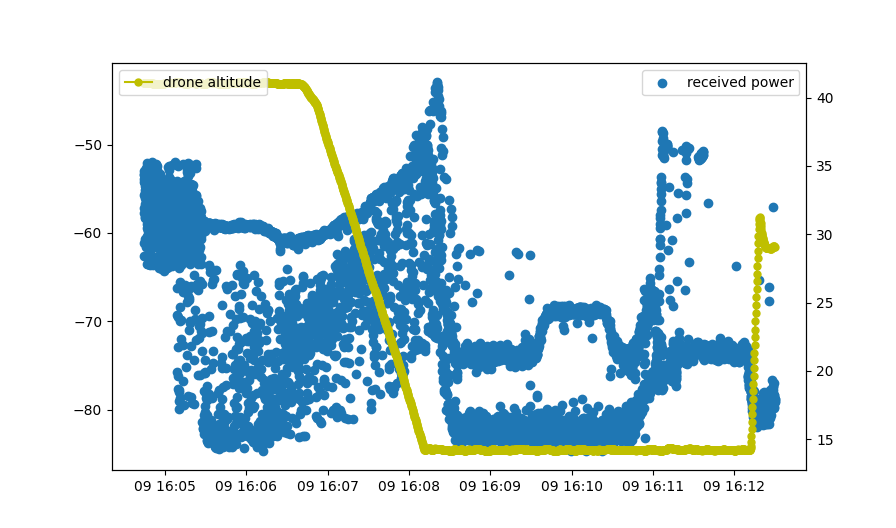

In [10]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(rx_times.values,rx_data.iloc[:,411].values, label = 'received power')
ax2.plot(chopper_times.datetime64, chopper_data[:,3]+1125, 'y', marker = 'o', markersize = 5, label = 'drone altitude')
ax.legend()
ax2.legend(loc = 'upper left')

In [11]:
start_time = '2021-05-09 16:05:30'
end_time = '2021-05-09 16:06:40'
zenith_chopper = chopper_data[(chopper_times.iso >= start_time) & (chopper_times.iso <= end_time)]
zenith_rx = rx_data[(rx_times.values >= Time(start_time, format = 'iso').datetime64) & 
                    (rx_times.values <=  Time(end_time, format = 'iso').datetime64)]

In [12]:
null_start = '2021-05-09 16:08:52'
null_end = '2021-05-09 16:09:13'
null_chopper = chopper_data[(chopper_times.iso >= null_start) & (chopper_times.iso <= null_end)]
null_rx = rx_data[(rx_times.values >= Time(null_start, format = 'iso').datetime64) & 
                    (rx_times.values <=  Time(null_end, format = 'iso').datetime64)]

<IPython.core.display.Javascript object>


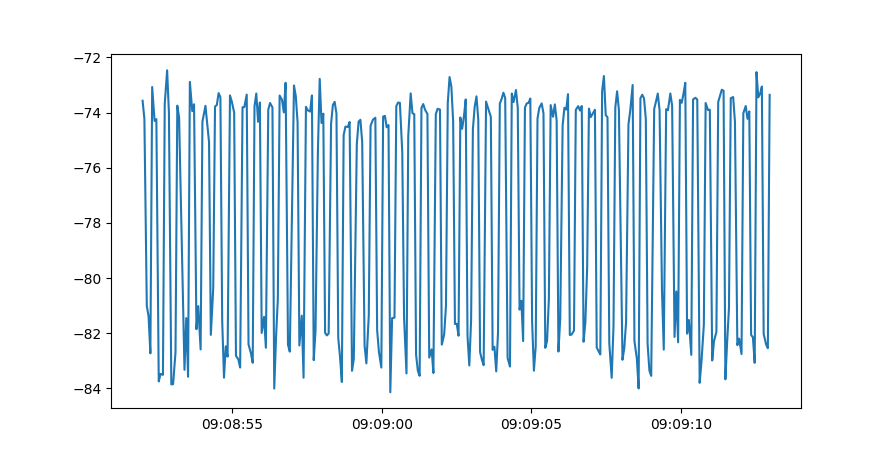

In [13]:
plt.figure()
#plt.plot(zenith_chopper[:,3]+1125)
#plt.scatter(zenith_rx.iloc[:,0], zenith_rx.iloc[:,411])
#plt.scatter(zenith_rx.iloc[:,0],zenith_rx.iloc[:,411])
plt.plot(null_rx.iloc[:,0],null_rx.iloc[:,411])

<IPython.core.display.Javascript object>


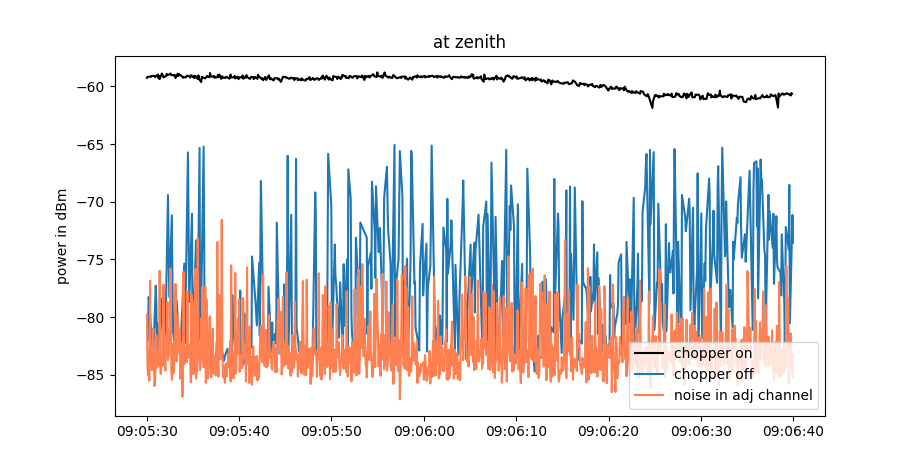

Text(0.5, 1.0, 'at zenith')

In [14]:
plt.figure()
plt.plot(zenith_rx[(zenith_rx.iloc[:,411]>= -62)].iloc[:,0],zenith_rx[(zenith_rx.iloc[:,411]>= -62)].iloc[:,411],'k', label = 'chopper on')
plt.plot(zenith_rx[(zenith_rx.iloc[:,411]< -65)].iloc[:,0],zenith_rx[(zenith_rx.iloc[:,411]< -65)].iloc[:,411], label= 'chopper off')
plt.plot(zenith_rx.iloc[:,0],zenith_rx.iloc[:,407],'coral', label = 'noise in adj channel')
plt.legend(loc = 'lower right')
plt.ylabel('power in dBm')
plt.title('at zenith')

<IPython.core.display.Javascript object>


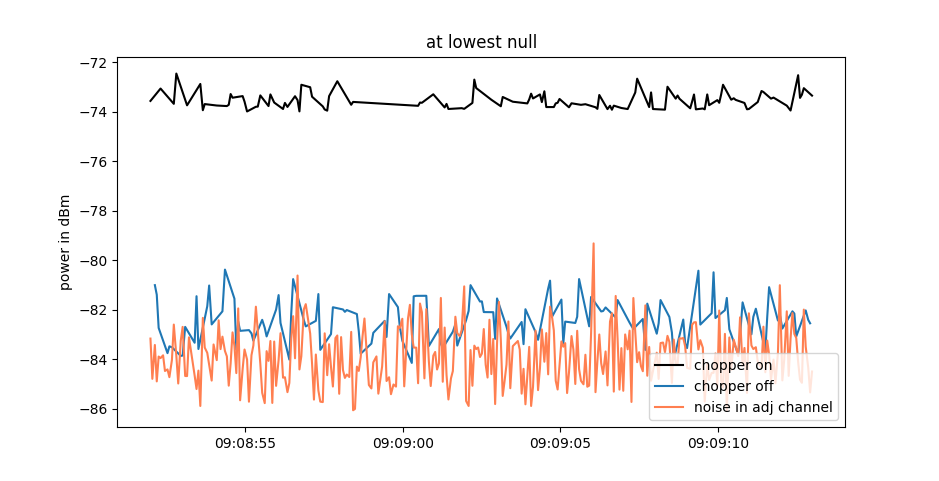

Text(0.5, 1.0, 'at lowest null')

In [15]:
plt.figure()
plt.plot(null_rx[(null_rx.iloc[:,411]>= -74)].iloc[:,0],null_rx[(null_rx.iloc[:,411]>= -74)].iloc[:,411],'k', label = 'chopper on')
plt.plot(null_rx[(null_rx.iloc[:,411]< -80)].iloc[:,0],null_rx[(null_rx.iloc[:,411]< -80)].iloc[:,411], label= 'chopper off')
plt.plot(null_rx.iloc[:,0], null_rx.iloc[:,407],'coral', label = 'noise in adj channel')
plt.legend(loc = 'lower right')
plt.ylabel('power in dBm')
plt.title('at lowest null')